In [1]:
import cv2
import os
import numpy as np
import json
import pandas as pd
import time
import torch
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift, shift

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

from datasets import RandomTransformationDataset
from models import *
from utils import get_transformation_matrix

In [ ]:
# Initial = fc
models_info = [
    {
        "folder": "02_resnet18_MSE",
        "checkpoint": "model-9.pt",
        "type": "concatenation"
    },
    {
        "folder": "16_sub_MSE_fc",
        "checkpoint": "checkpoint-20.pt",
        "type": "subtraction"
    },
    {
        "folder": "07_resnet18_MSE_corr_2",
        "checkpoint": "checkpoint-24.pt",
        "type": "correlation"
    },
]

m = models_info[2]
outputs_path = "/content/drive/MyDrive/outputs"
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initial_siamese_resnet18(1, 7, m["type"])
if m["type"] == "concatenation":
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device))
else:
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

In [4]:
# Reg
models_info = [
    {
        "folder": "17_cat_MSE_reg",
        "checkpoint": "checkpoint-20.pt",
        "channels": [1024, 128, 64],
        "type": "concatenation"
    },
    {
        "folder": "15_sub_MSE_reg",
        "checkpoint": "checkpoint-19.pt",
        "channels": [512, 128, 64],
        "type": "subtraction"
    },
    {
        "folder": "11_resnet18_wMSE_corr_reg_4", # 11_resnet18_wMSE_corr_reg_4, 08_resnet18_MSE_corr_reg
        "checkpoint": "checkpoint-17.pt", # 17, 20
        "channels": [384, 128, 64],
        "type": "correlation"
    },
]

m = models_info[2]
outputs_path = "/content/drive/MyDrive/outputs"
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = siamese_resnet18(1, 7, m["type"], m["channels"])
model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

Running on cuda


In [5]:
def warp_from_params_and_eval(img0, img1, params):
    tx, ty, sx, sy, shx, shy, q = params
    rows, cols = img0.shape
    center = (cols//2, rows//2)
    matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
    matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
    inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
    img1_warped = cv2.warpAffine(img1, inverse_matrix, (cols, rows))
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return img1_warped, mse, ssim 

def warp_and_eval(img0, img1, method="sift"):
    rows, cols = img0.shape
    if method == "sift":
        detector = cv2.xfeatures2d.SIFT_create()
    elif method == "orb":
        detector = cv2.ORB_create(nfeatures=10000)
    else:
        raise NotImplemented()
    
    kp1, d1 = detector.detectAndCompute(img1, None)
    kp2, d2 = detector.detectAndCompute(img0, None)

    if (d1 is None) or (d2 is None):
        return img1, np.nan, np.nan

    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)
    matches = matcher.match(d1, d2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*0.9)]

    no_of_matches = len(matches)
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt
    try:
        #homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
        homography, mask = cv2.estimateAffinePartial2D(p1, p2)
        img1_warped = cv2.warpAffine(img1, homography, (cols, rows))
        #print(f"{homography=}")
    except:
        return img1, np.nan, np.nan
    #img = cv2.drawMatches(img0, kp1, img0, kp2, matches[:100], img1, flags=2)
    #plt.imshow(img),plt.show()
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return homography, mse, ssim

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/data/test.pkl")
df.groupby(["patient_id"]).sample(1)


,full_path,relative_path,file_name,study,patient_id,eye,patient_record_num
1258,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00009_03_R/82.jpg,82.jpg,Study_02_00009_03_R,00009,R,03
13756,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00078_01_L/99.jpg,99.jpg,Study_02_00078_01_L,00078,L,01
15011,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00081_03_L/112.jpg,112.jpg,Study_02_00081_03_L,00081,L,03
17474,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00085_02_L/186.jpg,186.jpg,Study_02_00085_02_L,00085,L,02
20356,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00091_02_L/107.jpg,107.jpg,Study_02_00091_02_L,00091,L,02
22576,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00096_01_R/14.jpg,14.jpg,Study_02_00096_01_R,00096,R,01
24143,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00099_01_R/167.jpg,167.jpg,Study_02_00099_01_R,00099,R,01
24593,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00100_03_R/205.jpg,205.jpg,Study_02_00100_03_R,00100,R,03
28171,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00107_03_R/188.jpg,188.jpg,Study_02_00107_03_R,00107,R,03
28954,/content/drive/MyDrive/data/frame_sequences/St...,data/frame_sequences/Study_02_00108_01_R/238.jpg,238.jpg,Study_02_00108_01_R,00108,R,01


In [7]:
videos = ["Study_02_00078_01_L", "Study_02_00081_01_L", "Study_02_00085_01_R", "Study_02_00091_02_L", "Study_02_00096_02_L",
          "Study_02_00099_02_R", "Study_02_00108_02_L", "Study_02_00121_03_L", "Study_02_00124_01_R", "Study_02_00126_02_R", 
          "Study_02_00009_03_R", "Study_02_00100_03_R", "Study_02_00107_03_R", "Study_02_00113_01_R", "Study_02_00114_01_R", 
          "Study_02_00120_03_R"]

In [25]:
tr_only = True
reg_on_first = True
image_list = [[] for _ in range(len(videos))]
image_list_warped = [[] for _ in range(len(videos))]
image_list_warped_sift = [[] for _ in range(len(videos))]
image_list_warped_orb = [[] for _ in range(len(videos))]
image_list_warped_phase = [[] for _ in range(len(videos))]
mse0 = [[] for _ in range(len(videos))]
mse1 = [[] for _ in range(len(videos))]
mse2 = [[] for _ in range(len(videos))]
mse3 = [[] for _ in range(len(videos))]
ssim0 = [[] for _ in range(len(videos))]
ssim1 = [[] for _ in range(len(videos))]
ssim2 = [[] for _ in range(len(videos))]
ssim3 = [[] for _ in range(len(videos))]
mse_orb = [[] for _ in range(len(videos))]
ssim_orb = [[] for _ in range(len(videos))]
mse_sift = [[] for _ in range(len(videos))]
ssim_sift = [[] for _ in range(len(videos))]
mse_phase = [[] for _ in range(len(videos))]
ssim_phase = [[] for _ in range(len(videos))]
time_start = time.time()
for i, vid in enumerate(videos):
    #if i==1:
    #    break
    #video_name = "Study_02_00078_01_L"
    video_name = vid
    cap = cv2.VideoCapture(f"/content/drive/MyDrive/data/{video_name}.avi")
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0
    # Start converting the video
    with tqdm(total=video_length, unit=' frames') as pbar:
        while cap.isOpened():
            # Extract the frame

            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if not ret:
                continue
            if len(image_list[i]) == 0:
                mse0[i].append(np.nan)
                ssim0[i].append(np.nan)
                mse1[i].append(np.nan)
                ssim1[i].append(np.nan)
                mse_orb[i].append(np.nan)
                ssim_orb[i].append(np.nan)
                mse_sift[i].append(np.nan)
                ssim_sift[i].append(np.nan)
                mse_phase[i].append(np.nan)
                ssim_phase[i].append(np.nan)
                image_list[i].append(frame)
                image_list_warped[i].append(frame)
                image_list_warped_sift[i].append(frame)
                image_list_warped_orb[i].append(frame)
                image_list_warped_phase[i].append(frame)
            else:
                if reg_on_first:
                    frame0 = image_list_warped[i][0]
                    frame1 = frame
                else:
                    frame0 = image_list_warped[i][count-1]
                    frame1 = frame

                h = 500
                w = int(h * 1.5)
                rows, cols = frame0.shape
                center = (cols//2, rows//2)
                img0 = torch.unsqueeze(transforms.functional.to_tensor(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]), 1).to(device)
                img1 = torch.unsqueeze(transforms.functional.to_tensor(frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]), 1).to(device)

                start = time.perf_counter()
                outputs = model(img0, img1)
                end = time.perf_counter()
                #print(f"{count}, time: {end - start}")

                if tr_only:
                    tx, ty, _, _, _, _, _ = outputs.detach().cpu().numpy().reshape(-1).tolist()
                    mat = np.array([
                            [1, 0, tx],
                            [0, 1, ty],
                            [0, 0, 1],
                        ])
                    matrix_opencv = np.float32(mat.flatten()[:6].reshape(2, 3))
                    inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
                    frame1_warped = cv2.warpAffine(frame1, inverse_matrix, (cols, rows))
                    mse0[i].append(mean_squared_error(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    ssim0[i].append(structural_similarity(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    
                    #s, _, _ = phase_cross_correlation(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2])
                    #frame1_phase_warped = shift(frame1, shift=s.astype("int8"))
                    #mse_phase[i].append(mean_squared_error(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1_phase_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    #ssim_phase[i].append(structural_similarity(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1_phase_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    
                    #homography, sift_mse, sift_ssim = warp_and_eval(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], method="sift")
                    #mse_sift[i].append(sift_mse)
                    #ssim_sift[i].append(sift_ssim)
                    #try:
                    #    frame1_sift_warped = cv2.warpAffine(frame1, homography, (cols, rows))
                    #except:
                    #    frame1_sift_warped = frame1
                              
                    frame0 = frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]
                    framex_warped=frame1_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]
                    mask = (framex_warped != 0.0)
                    mse1[i].append(mean_squared_error(frame0[mask], framex_warped[mask]))
                    ssim1[i].append(structural_similarity(frame0[mask], framex_warped[mask]))

                    
                else:
                    tx, ty, sx, sy, shx, shy, q = outputs.detach().cpu().numpy().reshape(-1).tolist()
                    matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
                    matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
                    inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
                    frame1_warped = cv2.warpAffine(frame1, inverse_matrix, (cols, rows))

                    mse0[i].append(mean_squared_error(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    ssim0[i].append(structural_similarity(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    _, net_mse1, net_ssim1 = warp_from_params_and_eval(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], outputs.detach().cpu().numpy().reshape(-1).tolist())
                    mse1[i].append(net_mse1)
                    ssim1[i].append(net_ssim1)

                    #homography, orb_mse, orb_ssim = warp_and_eval(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], method="orb")
                    #mse_orb[i].append(orb_mse)
                    #ssim_orb[i].append(orb_ssim)
                    #try:
                    #    frame1_orb_warped = cv2.warpAffine(frame1, homography, (cols, rows))
                    #except:
                    #    frame1_orb_warped = frame1
                    
                    homography, sift_mse, sift_ssim = warp_and_eval(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], method="sift")
                    mse_sift[i].append(sift_mse)
                    ssim_sift[i].append(sift_ssim)
                    try:
                        frame1_sift_warped = cv2.warpAffine(frame1, homography, (cols, rows))
                    except:
                        frame1_sift_warped = frame1
                    
                    s, _, _ = phase_cross_correlation(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2])
                    frame1_phase_warped = shift(frame1, shift=s.astype("int8"))
                    mse_phase[i].append(mean_squared_error(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1_phase_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                    ssim_phase[i].append(structural_similarity(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], frame1_phase_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
                
                image_list[i].append(frame)
                image_list_warped[i].append(frame1_warped)
                #image_list_warped_phase[i].append(frame1_phase_warped)
                #image_list_warped_sift[i].append(frame1_sift_warped)
                #image_list_warped_orb[i].append(frame1_orb_warped)
                
                #cap.release()
                #break


            
            count = count + 1
            pbar.update(1)
            # If there are no more frames left
            if (count > (video_length-1)):
                # Log the time again
                time_end = time.time()
                # Release the feed
                cap.release()
                # Print stats
                break

100%|██████████| 252/252 [00:17<00:00, 14.72 frames/s]


In [32]:
d = {'mse0': mse0, 'mse1': mse1, 'ssim1': ssim1}
df = pd.DataFrame(d)
df["mse1_m"] = df.mse1.apply(np.nanmean)
df["mse1_std"] = df.mse1.apply(np.nanstd)
df["ssim1_m"] = df.ssim1.apply(np.nanmean)
df["ssim1_std"] = df.ssim1.apply(np.nanstd)
df.iloc[:1].describe()

,mse1_m,mse1_std,ssim1_m,ssim1_std
count,1.000000,1.000000,1.000000,1.00000
mean,73.602109,37.397348,0.731461,0.01884
std,NaN,NaN,NaN,NaN
min,73.602109,37.397348,0.731461,0.01884
25%,73.602109,37.397348,0.731461,0.01884
50%,73.602109,37.397348,0.731461,0.01884
75%,73.602109,37.397348,0.731461,0.01884
max,73.602109,37.397348,0.731461,0.01884


In [ ]:
#image_list_warped.insert(0, image_list[0])

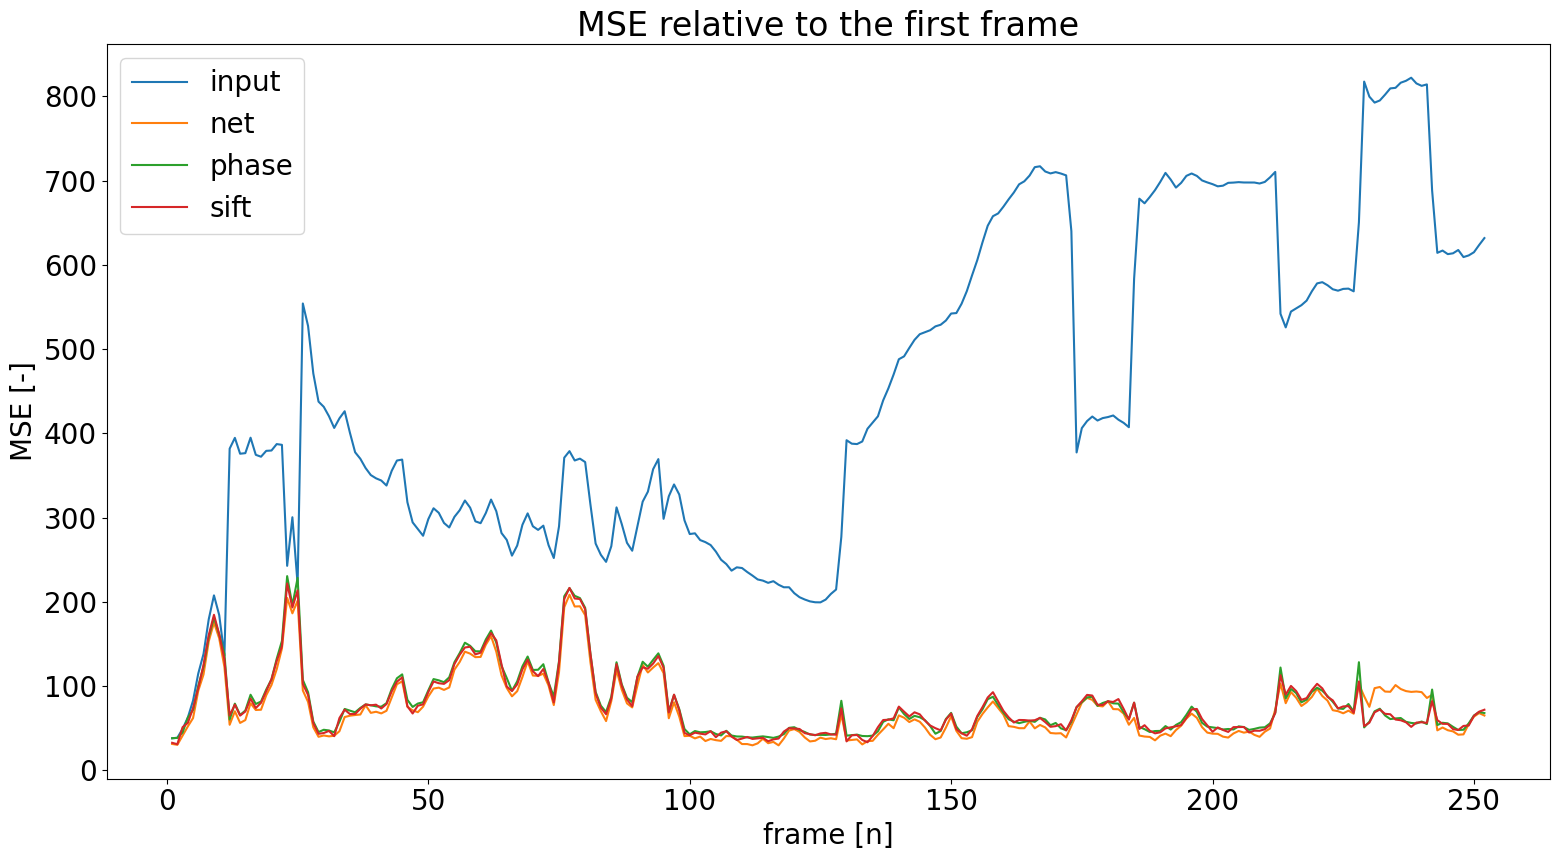

In [24]:
yep = 0
x = list(range(0, len(mse0[yep])))
plt.figure(figsize = (16,9))
plt.rc('font', size=20)
plt.title("MSE relative to the first frame")
plt.plot(x, mse0[yep], label = "input")
plt.plot(x, mse1[yep], label = "net")
plt.plot(x, mse_phase[yep], label = "phase")
plt.plot(x, mse_sift[yep], label = "sift")
#plt.plot(x, mse_orb[yep], label = "orb")
plt.xlabel("frame [n]")
plt.ylabel("MSE [-]")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval3-mse-tronly.png"))
plt.show()

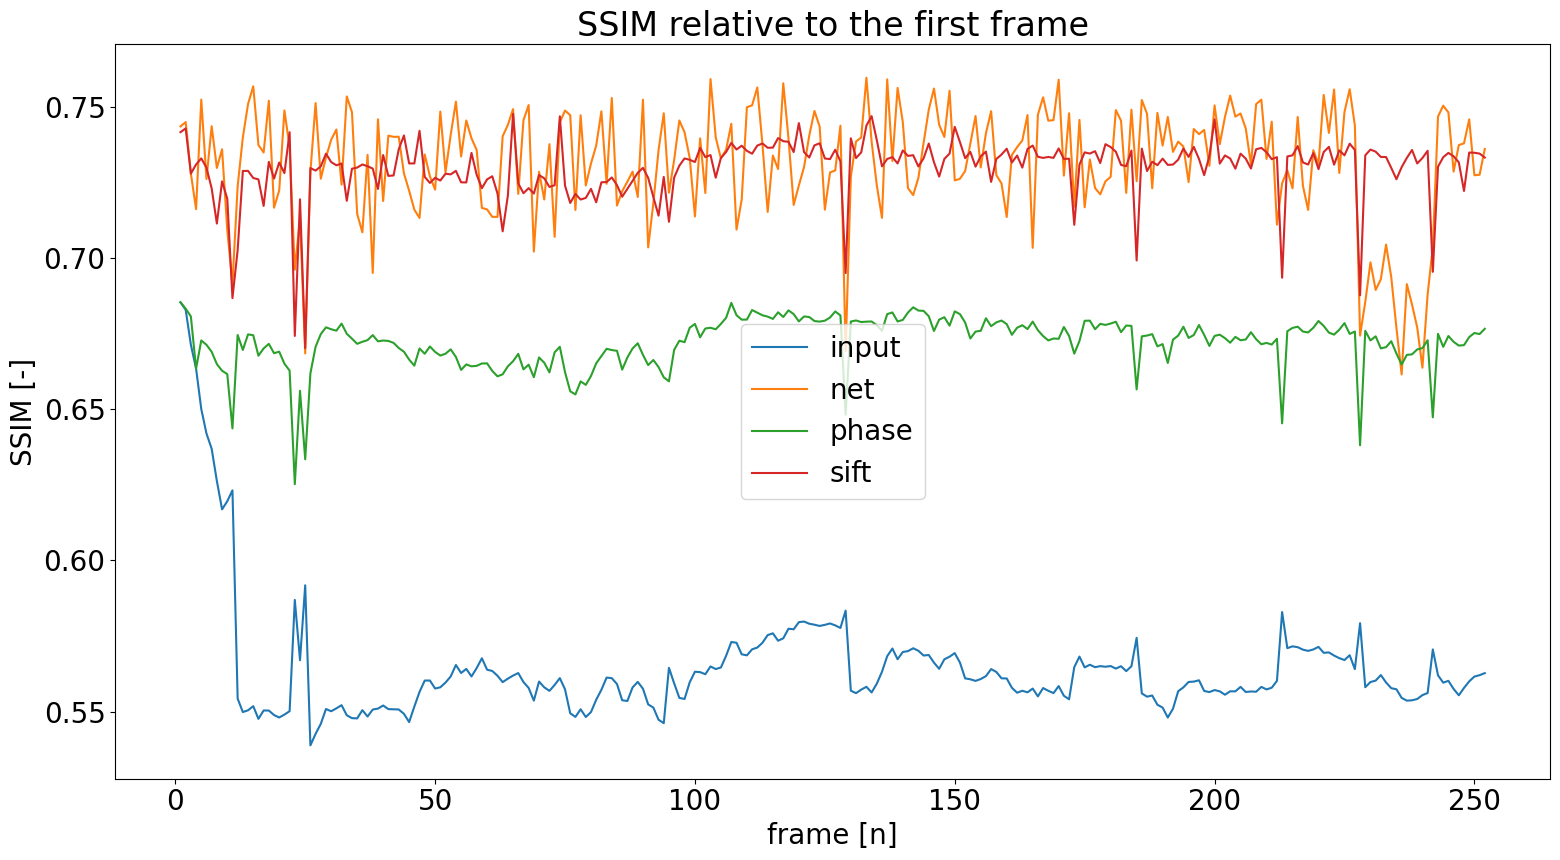

In [13]:
x = list(range(0, len(mse0[yep])))
plt.figure(figsize = (16,9))
plt.rc('font', size=20)

plt.title("SSIM relative to the first frame")
plt.plot(x, ssim0[yep], label = "input")
plt.plot(x, ssim1[yep], label = "net")
plt.plot(x, ssim_phase[yep], label = "phase")
plt.plot(x, ssim_sift[yep], label = "sift")
#plt.plot(x, ssim_orb[yep], label = "orb")

plt.xlabel("frame [n]")
plt.ylabel("SSIM [-]")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval3-ssim1.png"))
plt.show()

In [ ]:
len(image_list_warped_sift)

253

In [30]:
mse0_hmm = [[] for _ in range(len(videos))]
mse1_hmm = [[] for _ in range(len(videos))]
mse2_hmm = [[] for _ in range(len(videos))]
mse3_hmm = [[] for _ in range(len(videos))]
mse4_hmm = [[] for _ in range(len(videos))]
ssim0_hmm = [[] for _ in range(len(videos))]
ssim1_hmm = [[] for _ in range(len(videos))]
ssim2_hmm = [[] for _ in range(len(videos))]
ssim3_hmm = [[] for _ in range(len(videos))]
ssim4_hmm = [[] for _ in range(len(videos))]
for j, _ in tqdm(enumerate(videos)):
    if j == 9:
        break
    for i in range(len(image_list[j])):
        if i == 0:
            mse0_hmm[j].append(np.nan)
            mse1_hmm[j].append(np.nan)
            mse2_hmm[j].append(np.nan)
            mse3_hmm[j].append(np.nan)
            mse4_hmm[j].append(np.nan)
            ssim0_hmm[j].append(np.nan)
            ssim1_hmm[j].append(np.nan)
            ssim2_hmm[j].append(np.nan)
            ssim3_hmm[j].append(np.nan)
            ssim4_hmm[j].append(np.nan)
            continue
        i01 = image_list[j][i-1]
        i02 = image_list[j][i]
        i11 = image_list_warped[j][i-1]
        i12 = image_list_warped[j][i]
        i21 = image_list_warped_phase[j][i-1]
        i22 = image_list_warped_phase[j][i]
        i31 = image_list_warped_sift[j][i-1]
        i32 = image_list_warped_sift[j][i]
        i41 = image_list_warped_orb[j][i-1]
        i42 = image_list_warped_orb[j][i]
        
        mse0_hmm[j].append(mean_squared_error(i01[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i02[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        mse1_hmm[j].append(mean_squared_error(i11[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i12[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        mse2_hmm[j].append(mean_squared_error(i21[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i22[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        mse3_hmm[j].append(mean_squared_error(i31[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i32[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        mse4_hmm[j].append(mean_squared_error(i41[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i42[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        ssim0_hmm[j].append(structural_similarity(i01[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i02[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        ssim1_hmm[j].append(structural_similarity(i11[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i12[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        ssim2_hmm[j].append(structural_similarity(i21[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i22[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        ssim3_hmm[j].append(structural_similarity(i31[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i32[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))
        ssim4_hmm[j].append(structural_similarity(i41[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2], i42[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]))


#plt.figure(figsize = (16,9))
#plt.title("MSE between consecutive frames")
#plt.rc('font', size=20) 
#plt.plot(x, mse0_hmm, label = "input")
#plt.plot(x, mse1_hmm, label = "net")
#plt.plot(x, mse2_hmm, label = "phase")
#plt.xlabel("frame [n]")
#plt.ylabel("MSE [-]")
#plt.legend()
#plt.tight_layout()
#plt.show()



9it [05:37, 37.52s/it]


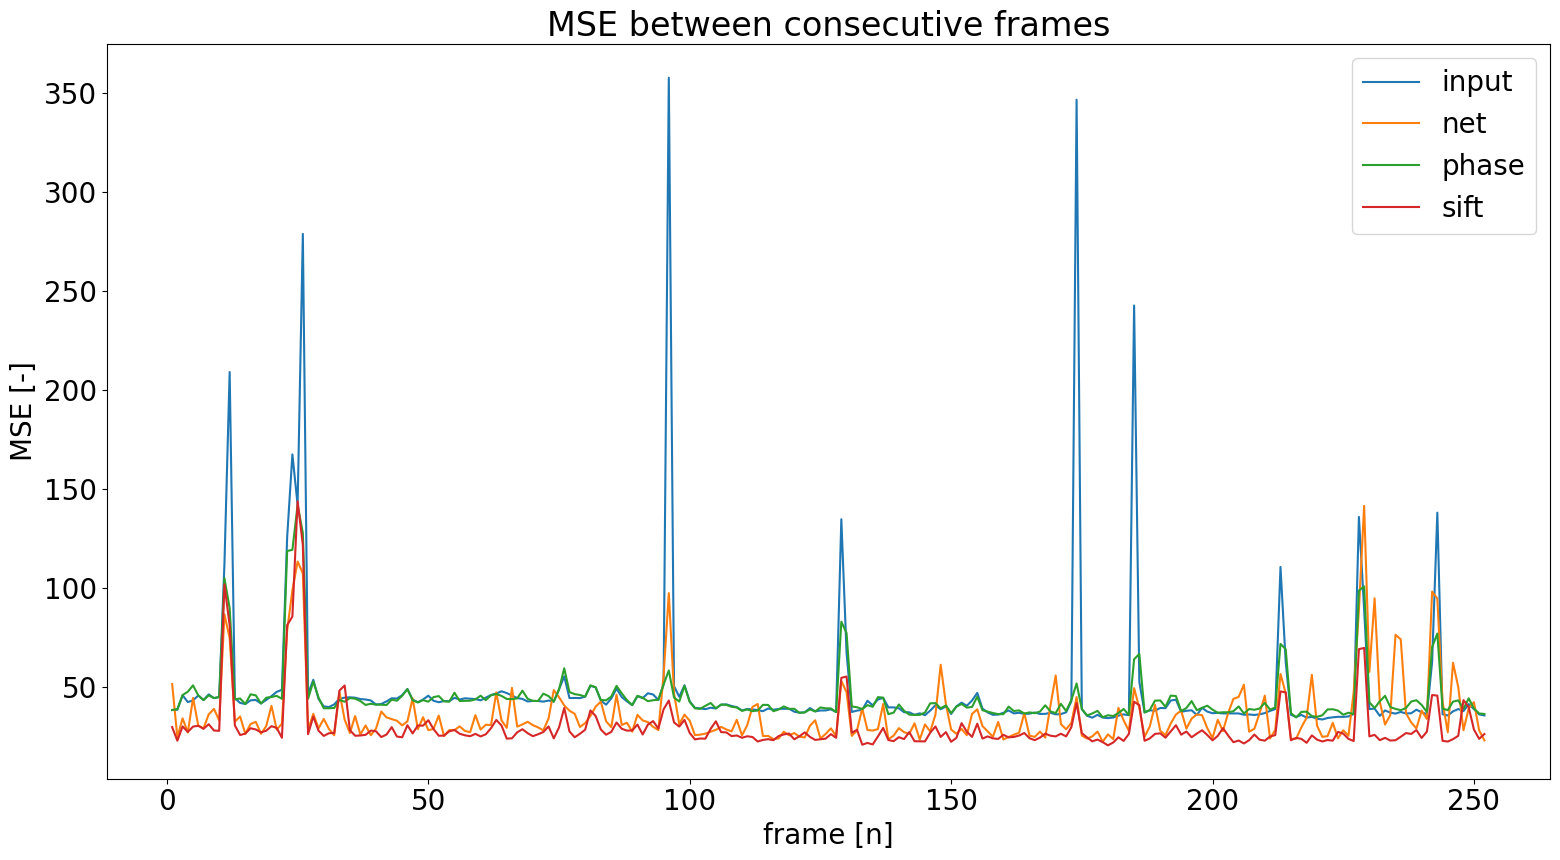

In [56]:
x = list(range(0, len(mse0[yep])))
plt.figure(figsize = (16,9))
plt.rc('font', size=20)
plt.title("MSE between consecutive frames")
plt.plot(x, mse0_hmm[yep], label = "input")
plt.plot(x, mse1_hmm[yep], label = "net")
plt.plot(x, mse2_hmm[yep], label = "phase")
plt.plot(x, mse3_hmm[yep], label = "sift")
#plt.plot(x, mse4_hmm[yep], label = "orb")
plt.xlabel("frame [n]")
plt.ylabel("MSE [-]")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval3-mse2.png"))
plt.show()

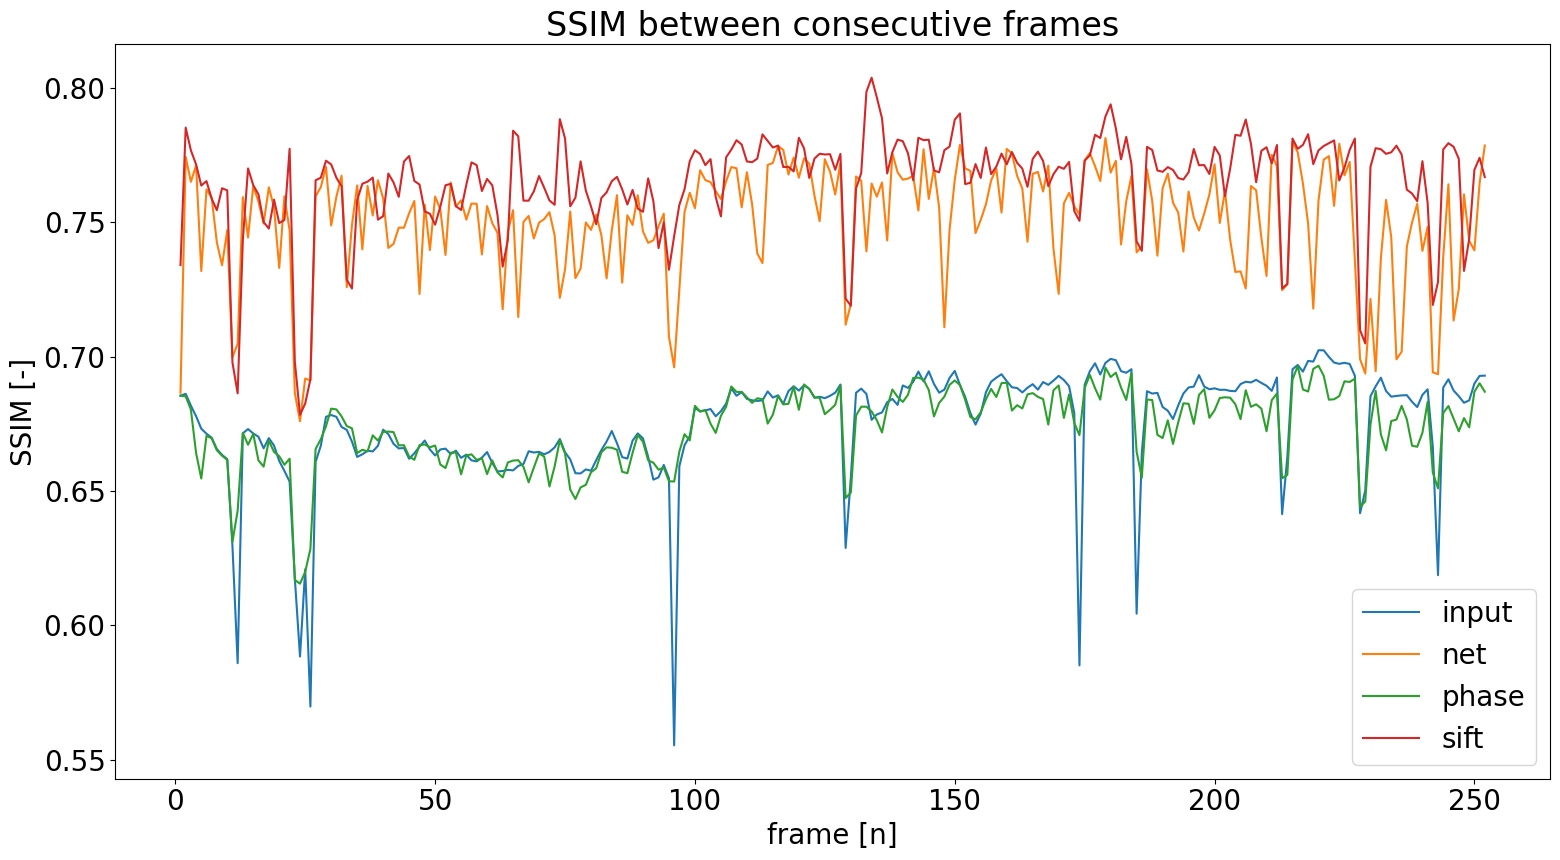

In [57]:
x = list(range(0, len(mse0[yep])))
plt.figure(figsize = (16,9))
plt.rc('font', size=20)

plt.title("SSIM between consecutive frames")
plt.plot(x, ssim0_hmm[yep], label = "input")
plt.plot(x, ssim1_hmm[yep], label = "net")
plt.plot(x, ssim2_hmm[yep], label = "phase")
plt.plot(x, ssim3_hmm[yep], label = "sift")
#plt.plot(x, ssim4_hmm[yep], label = "orb")
plt.xlabel("frame [n]")
plt.ylabel("SSIM [-]")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval3-ssim2.png"))
plt.show()

In [22]:
d = {'mse0': mse0, 'mse1': mse1, 'mse_phase': mse_phase, 'mse_sift': mse_sift, 'ssim0': ssim0, 'ssim1': ssim1, 'ssim_phase': ssim_phase, 'ssim_sift': ssim_sift,}
#d = {'mse0': mse0, 'mse1': mse1, 'mse_phase': mse_phase, 'mse_sift': mse_sift, 'mse_orb': mse_orb, 'ssim0': ssim0, 'ssim1': ssim1, 'ssim_phase': ssim_phase, 'ssim_sift': ssim_orb, 'ssim_phase': ssim_phase, 'mse0_hmm': mse0_hmm, 'mse1_hmm': mse1_hmm, 'mse2_hmm': mse2_hmm, 'mse3_hmm': mse3_hmm, 'mse4_hmm': mse4_hmm, 'ssim0_hmm': ssim0_hmm, 'ssim1_hmm': ssim1_hmm, 'ssim2_hmm': ssim2_hmm, 'ssim3_hmm': ssim3_hmm, 'ssim4_hmm': ssim4_hmm}
df = pd.DataFrame(d)
df = df.iloc[:1]
df

,mse0,mse1,mse_phase,mse_sift,ssim0,ssim1,ssim_phase
0,"[nan, 38.12088, 38.71112, 49.279752, 62.659893...","[nan, 31.359344, 30.33144, 41.222330666666664,...","[nan, 38.12088, 38.574389333333336, 45.0015066...","[nan, 32.734738666666665, 31.042906666666667, ...","[nan, 0.6854734710056803, 0.6829685232696434, ...","[nan, 0.7437038123300617, 0.7451361607334032, ...","[nan, 0.6854734710056803, 0.683352180847706, 0..."


In [46]:
#df.to_csv(os.path.join("/content/drive/MyDrive/outputs", "outputs-vid-comp-all.csv"))

In [20]:
#df = pd.read_csv("/content/drive/MyDrive/outputs/outputs-vid-comp-all.csv")
df.mse0 = df.mse0.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.mse0 = df.mse0.apply(lambda x: np.where(x == 0, np.nan, x))
df.mse1 = df.mse1.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.mse1 = df.mse1.apply(lambda x: np.where(x == 0, np.nan, x))
df.mse_phase = df.mse_phase.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.mse_phase = df.mse_phase.apply(lambda x: np.where(x == 0, np.nan, x))
df.mse_sift = df.mse_sift.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.mse_sift = df.mse_sift.apply(lambda x: np.where(x == 0, np.nan, x))
df.ssim0 = df.ssim0.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.ssim0 = df.ssim0.apply(lambda x: np.where(x == 0, np.nan, x))
df.ssim1 = df.ssim1.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.ssim1 = df.ssim1.apply(lambda x: np.where(x == 0, np.nan, x))
df.ssim_phase = df.ssim_phase.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.ssim_phase = df.ssim_phase.apply(lambda x: np.where(x == 0, np.nan, x))
df.ssim_sift = df.ssim_sift.apply(lambda x: np.array(json.loads(x.replace("nan", "0"))))
df.ssim_sift = df.ssim_sift.apply(lambda x: np.where(x == 0, np.nan, x))

AttributeError: ignored

In [23]:
df["mse0_m"] = df.mse0.iloc[:1].apply(np.nanmean)
df["mse0_std"] = df.mse0.iloc[:1].apply(np.nanstd)
df["mse1_m"] = df.mse1.iloc[:1].apply(np.nanmean)
df["mse1_std"] = df.mse1.iloc[:1].apply(np.nanstd)
df["mse_phase_m"] = df.mse_phase.iloc[:1].apply(np.nanmean)
df["mse_phase_std"] = df.mse_phase.iloc[:1].apply(np.nanstd)
df["mse_sift_m"] = df.mse_sift.iloc[:1].apply(np.nanmean)
df["mse_sift_std"] = df.mse_sift.iloc[:1].apply(np.nanstd)

df["ssim0_m"] = df.ssim0.iloc[:1].apply(np.nanmean)
df["ssim0_std"] = df.ssim0.iloc[:1].apply(np.nanstd)
df["ssim1_m"] = df.ssim1.iloc[:1].apply(np.nanmean)
df["ssim1_std"] = df.ssim1.iloc[:1].apply(np.nanstd)
df["ssim_phase_m"] = df.ssim_phase.iloc[:1].apply(np.nanmean)
df["ssim_phase_std"] = df.ssim_phase.iloc[:1].apply(np.nanstd)
df["ssim_sift_m"] = df.ssim_sift.iloc[:1].apply(np.nanmean)
df["ssim_sift_std"] = df.ssim_sift.iloc[:1].apply(np.nanstd)

#df["mse_orb_m"] = df.mse_orb.apply(np.nanmean)
#df["mse_orb_std"] = df.mse_orb.apply(np.nanstd)
#df["mse0_hmm_m"] = df.mse0_hmm.apply(np.nanmean)
#df["mse0_hmm_std"] = df.mse0_hmm.apply(np.nanstd)
#df["mse1_hmm_m"] = df.mse1_hmm.apply(np.nanmean)
#df["mse1_hmm_std"] = df.mse1_hmm.apply(np.nanstd)
#df["mse2_hmm_m"] = df.mse2_hmm.apply(np.nanmean)
#df["mse2_hmm_std"] = df.mse2_hmm.apply(np.nanstd)
#df["mse3_hmm_m"] = df.mse3_hmm.apply(np.nanmean)
#df["mse3_hmm_std"] = df.mse3_hmm.apply(np.nanstd)
#df["mse4_hmm_m"] = df.mse4_hmm.apply(np.nanmean)
#df["mse4_hmm_std"] = df.mse4_hmm.apply(np.nanstd)


df.describe()

AttributeError: ignored

In [16]:
df.mse0.iloc[:1]

0    [nan, 38.12088, 38.71112, 49.279752, 62.659893...
Name: mse0, dtype: object

In [ ]:
yep = 0
x = list(range(0, len(mse0[yep])))
plt.figure(figsize = (16,9))
plt.rc('font', size=20)

plt.title("SSIM relative to the first frame")
plt.plot(x, ssim0_hmm[yep], label = "input")
plt.plot(x, ssim1_hmm[yep], label = "net")
plt.plot(x, ssim2_hmm[yep], label = "phase")
plt.plot(x, ssim3_hmm[yep], label = "sift")
#plt.plot(x, ssim4_hmm[yep], label = "orb")


plt.legend()
plt.tight_layout()
plt.show()

In [30]:
idk = 0
video_name = videos[0]
images = image_list[idk]
warped = image_list_warped[idk]

img = np.concatenate((images[0], warped[0]), axis = 1)


# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
#out = cv2.VideoWriter(os.path.join(outputs_path, folder, f'{video_name}.mp4'), cv2.VideoWriter_fourcc(*'XVID'), 15, (img.shape[1], img.shape[0]), 0)
out = cv2.VideoWriter(os.path.join(outputs_path, "video", f'tr_{video_name}.mp4'), cv2.VideoWriter_fourcc(*'XVID'), 15, (img.shape[1], img.shape[0]), 0)

for image, image_warped in zip(images, warped):
    img = np.concatenate((image, image_warped), axis = 1)
    I = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    cv2.putText(img=I, text='Original', org=(325, 75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255, 0, 255), thickness=3)
    cv2.putText(img=I, text='Registered', org=(1275, 75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255, 0, 255), thickness=3)
    out.write(I)

cv2.destroyAllWindows()
out.release()

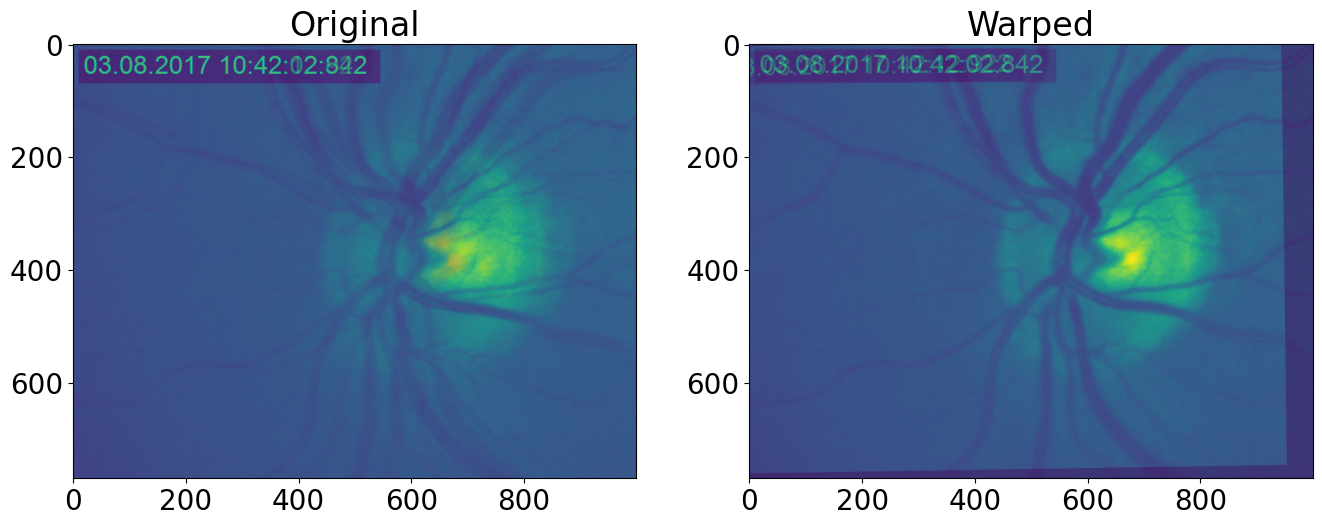

In [ ]:
plt.figure(figsize = (16,9))
plt.subplot(121)
plt.title('Original')
plt.imshow(frame0)
plt.imshow(frame1, alpha=0.4)

plt.subplot(122)
plt.title('Warped')
plt.imshow(frame0)
plt.imshow(frame1_warped, alpha=0.4)

plt.show()